<a href="https://colab.research.google.com/github/nicolassalomon96/Traffic_sign_classifier/blob/main/Traffic_sign_classifier_(dataset_augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de Señales de Tránsito

Nombre y Apellido: Nicolás Salomón

Email: nicolassalomon96@gmail.com

En este proyecto se propone realizar un clasificador de señales de tránsito empleando redes nueronales convolucionales

In [ ]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import imageio as io
import pandas as pd
from skimage import transform
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga y exploración del dataset

In [ ]:
!unzip "/content/drive/MyDrive/Posgrado/traffic_sign_detection/traffic_sign_classifier/Dataset/GTSRD.zip" -d "/content/GTSRD" > /dev/null #Se redirecciona a /dev/null para que no se muestre el resultado por pantalla

In [ ]:
def load_class_names(path_directory):
    path_class_names =  os.path.join(path_directory,"class_names.csv")
    class_names = open(path_class_names).read().strip().split("\n")[1:]
    class_names = [l.split(',')[1] for l in class_names] #creo una lista con los nombres de cada label
    return class_names

def load_images(path_directory, path_csv):
    #path_csv: path del archivo .csv que contiene información sobre cada imagen del set (train.csv o test.csv)
    labels = []
    images = []
    data = open(path_csv).read().strip().split("\n")[1:] #leo el archivo .csv y separo las filas en una lista
    
    for (count, values) in enumerate(data): #count=contador - values=valor de cada elemento de data mientras itera
        (label, image_path) = values.strip().split(',')[-2:] #separo el classID (label) y el path de la imagen
        image_path = os.path.join(path_directory, image_path) #crea el path completo de la imagen
        image = cv2.imread(image_path) #lee la imagen
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image, dtype='uint8')
        #image = image/255
        #image = cv2.resize(image, (32, 32)) #reescala la imagen al tamaño indicado: 28x28 pixeles

        #Actualizo la lista de imagenes y de labels
        #images = np.append(images,image)
        images.append(image)
        labels.append(int(label))

    images = np.array(images, dtype=object)#.astype('uint8')/255 #convierte las imagenes finales en arreglo numpy para facilitar el manejo posterior
    labels = np.array(labels, dtype=int) #convierte la lista de labels en un arreglo numpy
    
    #images.astype('uint8')
    #labels = np.array(labels, dtype=int)

    return images, labels

def save_images(path_save, images):
  for i in range(images.shape[0]):
    filename = f'{path_save}/image_{str(i)}.png'
    image = cv2.cvtColor(cv2.resize(images[i], (64,64)), cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename, image) 

Importamos el dataset

In [ ]:
path = "/content/GTSRD"
class_names_path = "/content/drive/MyDrive/Posgrado/traffic_sign_detection/traffic_sign_classifier/Dataset"
path_csv_train = os.path.join(path,'Train.csv')
path_csv_test = os.path.join(path,'Test.csv')

dataset_train_images, dataset_train_labels = load_images(path, path_csv_train)
train_images, valid_images, train_labels, valid_labels = train_test_split(dataset_train_images, dataset_train_labels, test_size=0.2, random_state=1)
test_images, test_labels = load_images(path, path_csv_test)
class_names = load_class_names(class_names_path)

Set de entrenamiento: 31367 imágenes
Set de validación: 7842 imágenes
Set de prueba: 12630 imágenes


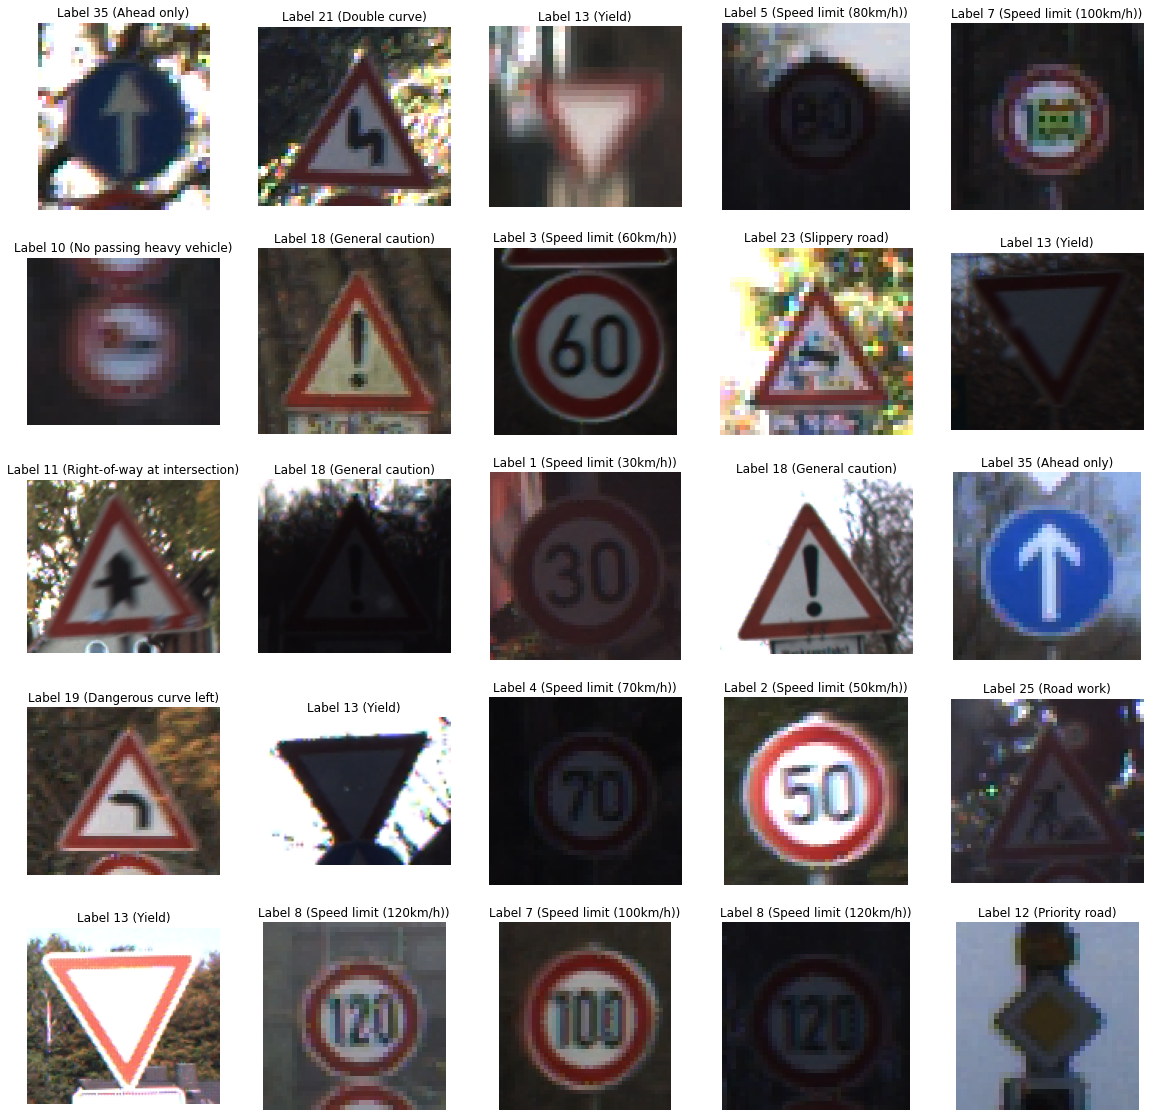

In [ ]:
print("Set de entrenamiento:",train_images.shape[0],"imágenes")
print("Set de validación:",valid_images.shape[0],"imágenes")
print("Set de prueba:",test_images.shape[0],"imágenes")

plt.figure(figsize=(20,20))
for i in range(25):
    n =  random.randint(0, train_images.shape[0] - 1)
    image = train_images[n]
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.title("Label {0} ({1})".format(train_labels[n],class_names[train_labels[n]]))
    plt.imshow(image)

plt.show()

In [ ]:
pd.read_csv('/content/drive/MyDrive/Posgrado/traffic_sign_detection/traffic_sign_classifier/Dataset/class_names.csv')

,labels,names
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


Señal con mayor cantidad de datos (entrenamiento): Speed limit (50km/h) - 1794 imágenes
Señal con menor cantidad de datos (entrenamiento): Speed limit (20km/h) - 167 imágenes


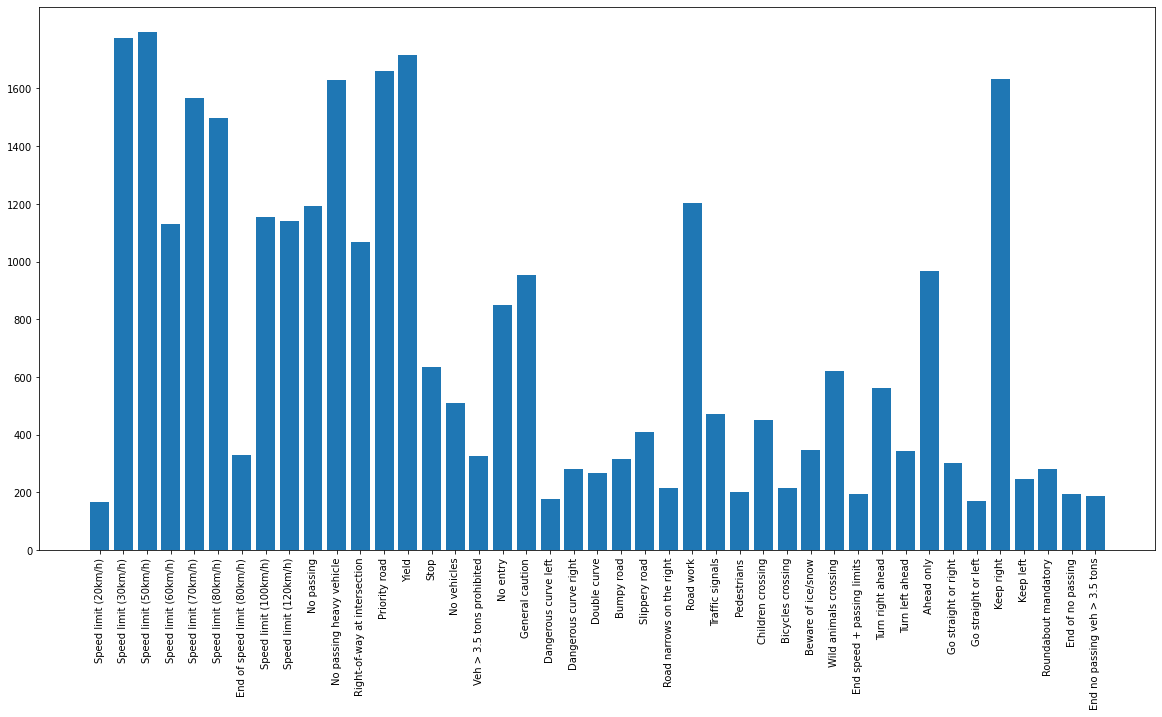

In [ ]:
#Displays class distribution and class examples
def get_histogram_data(x, y, class_names):
    classes = np.unique(y, return_index = True, return_counts = True)
    #print(classes)
    print(f"Señal con mayor cantidad de datos (entrenamiento): {class_names[np.argmax(classes[2])]} - {np.max(classes[2])} imágenes")
    print(f"Señal con menor cantidad de datos (entrenamiento): {class_names[np.argmin(classes[2])]} - {np.min(classes[2])} imágenes")
    plt.figure(1, figsize=(20,10))
    plt.bar(class_names, classes[2])
    plt.xticks(rotation=90)
    plt.yticks(range(0,np.max(classes[2]),200))
    plt.show()
    
get_histogram_data(train_images, train_labels, class_names)

In [ ]:
!mkdir '/content/GTSRD_valid'
!mkdir '/content/GTSRD_test'

In [ ]:
path_save_valid = '/content/GTSRD_valid'
save_images(path_save_valid, valid_images)

path_save_test = '/content/GTSRD_test'
save_images(path_save_test, test_images)

with open("/content/valid_labels.pickle", "wb") as f:
    pickle.dump(valid_labels, f)

with open("/content/test_labels.pickle", "wb") as f:
    pickle.dump(test_labels, f)

In [ ]:
!zip -r -q 'valid_signs' '/content/GTSRD_valid'
!zip -r -q 'test_signs' '/content/GTSRD_test'
!cp '/content/valid_signs.zip' '/content/drive/MyDrive'
!cp '/content/test_signs.zip' '/content/drive/MyDrive'
!cp '/content/test_labels.pickle' '/content/drive/MyDrive'
!cp '/content/valid_labels.pickle' '/content/drive/MyDrive'

In [ ]:
valid_labels = pd.read_pickle('/content/valid_labels.pickle')

Veh > 3.5 tons prohibited


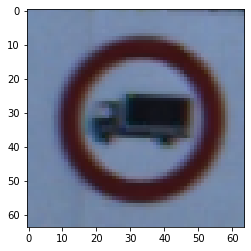

In [ ]:
print(class_names[test_labels[0]])
image = cv2.imread(f'/content/GTSRD_test/image_0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## Existe mucha disparidad en los datos, es necesario emparejar el dataset --> Augmento de datos

In [ ]:
classes = np.unique(train_labels, return_index = True, return_counts = True)
classes

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([123,  21,   2,  37,  47,  59,  69,  10,  35,  40,  17,  25,  30,
          4,   8,  15,  79,  55,   3,  90,  13, 305, 329, 158, 295,   7,
          1,  42,  53, 219,  20,   0,  36,  26, 221,  32, 167,  22,   9,
        129,  33,   6, 169]),
 array([ 167, 1775, 1794, 1132, 1568, 1498,  331, 1155, 1141, 1192, 1629,
        1067, 1661, 1716,  634,  510,  327,  851,  955,  177,  281,  268,
         317,  410,  214, 1204,  471,  200,  452,  215,  348,  621,  193,
         562,  345,  969,  301,  172, 1634,  247,  280,  195,  188]))

In [ ]:
!mkdir 'GTSRD_augmented_local'

In [ ]:
#Calculates required number of examples per class, then augments examples by randomly scaling, rotating, translating, and shearing images from original dataset
#np.unique, return_index = True --> posición de la primera ocurrencia, return_counts = True --> cantidad de ocurrecncias
def augment_pipeline(x, y):
    image_addition = 500 #Imágenes extra a agregar, sumadas a la categoria de mayor cantidad de imagenes
    output_shape=(64,64)
    # output_shape=(32,32)
    new_x = []
    new_y = []
    classes = np.unique(y, return_index = True, return_counts = True)
    maxclass = np.argmax(classes[2])
    j = 0

    #Copiamos las imagenes orginales redimensionandolas
    for z in range(x.shape[0]):
        filename = f'/content/GTSRD_augmented_local/image_{str(j)}.png'
        image = cv2.cvtColor(cv2.resize(x[z], output_shape), cv2.COLOR_RGB2BGR)
        cv2.imwrite(filename, image)
        j += 1
        new_y.append(y[z])

    #Cálculo de la cantidad de imagenes nuevas para emparejar el dataset y augmento de las mismas
    for req_label in range(len(classes[0])):
        req_images = classes[2][maxclass] - classes[2][req_label] + image_addition
        indices = []
        
        for indice, elemento in enumerate(y):
          if elemento == req_label:
            indices.append(indice)

        for z in range(req_images):

            random_indice = random.choice(indices)          
            tform = transform.AffineTransform(scale = (random.uniform(0.9,1.1), random.uniform(0.9,1.1)), rotation = random.uniform(-0.5,0.5), translation = (random.uniform(-5,5), random.uniform(-5,5)))
            img = transform.warp(x[random_indice], tform, output_shape=output_shape, order = 1, mode = 'edge')

            filename = f'/content/GTSRD_augmented_local/image_{str(j)}.png'
            image = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2BGR)
            cv2.imwrite(filename, image)
            j += 1
            new_y.append(y[random_indice])

    return np.array(new_y, dtype=int)

In [ ]:
train_labels_AD = augment_pipeline(train_images, train_labels)
train_labels_AD.shape

(98642,)

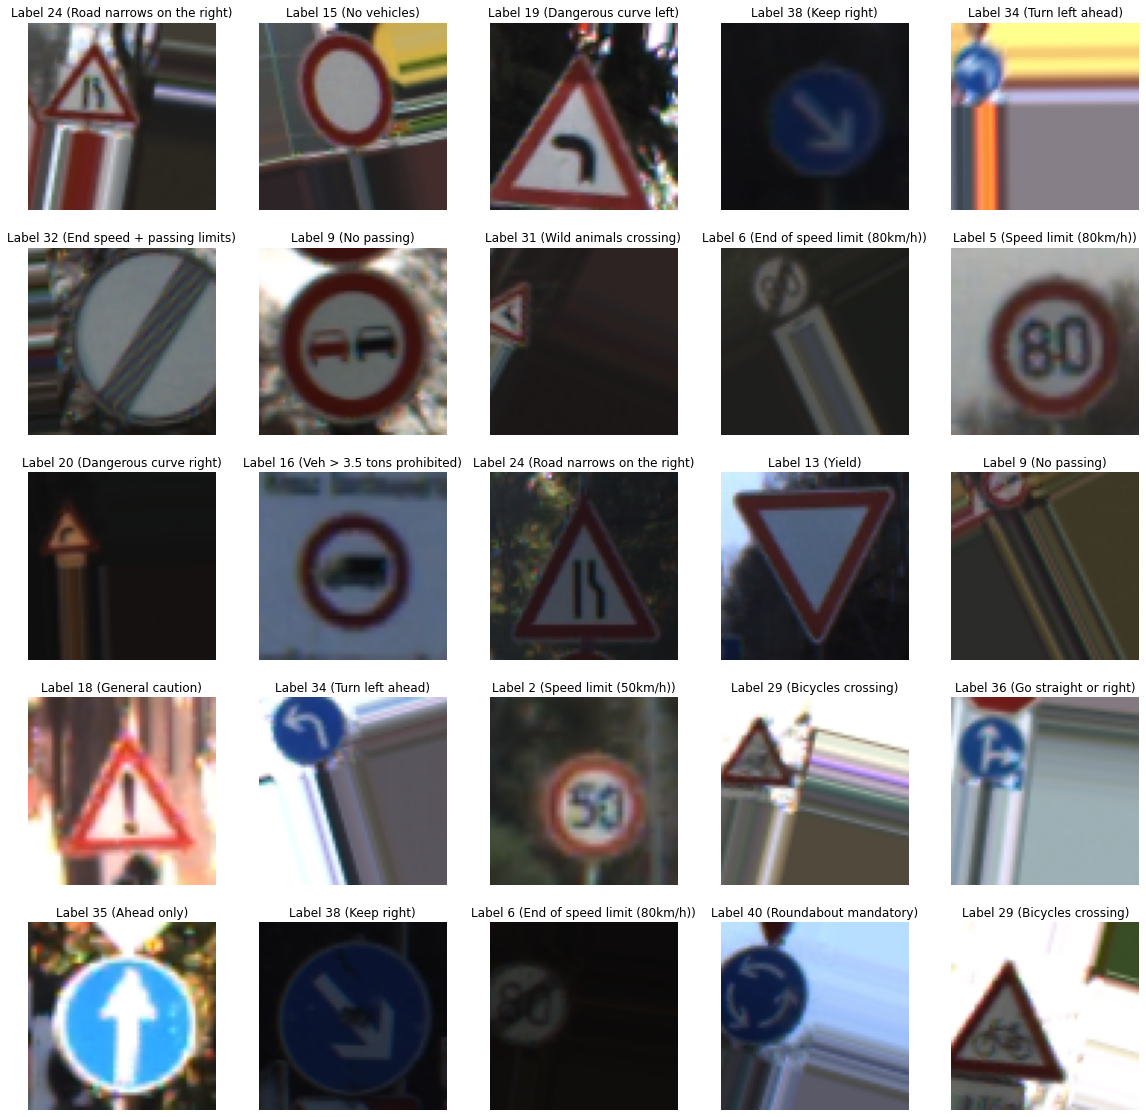

In [ ]:
plt.figure(figsize=(20,20))
for i in range(25):
    n =  random.randint(0, train_labels_AD.shape[0] - 1)
    image = cv2.imread(f'/content/GTSRD_augmented_local/image_{n}.png')
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.title("Label {0} ({1})".format(train_labels_AD[n],class_names[train_labels_AD[n]]))
    plt.imshow(image)

plt.show()

In [ ]:
with open("/content/train_labels_AD.pickle", "wb") as f:
    pickle.dump(train_labels_AD, f)

In [ ]:
!zip -r -q 'GTSRD_train' '/content/GTSRD_augmented_local'

In [ ]:
!cp '/content/GTSRD_train.zip' '/content/drive/MyDrive'
!cp '/content/train_labels_AD.pickle' '/content/drive/MyDrive'

Prueba final luego del emparejamiento del dataset

In [ ]:
def load_train_aug_images(path_images_folder):
    #path_csv: path del archivo .csv que contiene información sobre cada imagen del set (train.csv o test.csv)
    images = [] 
    images_list = os.listdir(path_images_folder)
    
    for _, path in enumerate(images_list): #count=contador - values=valor de cada elemento de data mientras itera
        image_path = os.path.join(path_images_folder, path) #crea el path completo de la imagen
        image = cv2.imread(image_path).astype('uint8') #lee la imagen
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = image/255
        #Actualizo la lista de imagenes y de labels
        images.append(image)
 
    images = np.array(images, dtype=object)#.astype('uint8')/255 #convierte las imagenes finales en arreglo numpy para facilitar el manejo posterior
    return images

In [ ]:
path_images_folder = '/content/GTSRD_augmented_local'
train_images_AD = load_train_aug_images(path_images_folder)

In [ ]:
# Open file using pickle
def open_file(input_file):
    with open(input_file, mode='rb') as f:
        train_labels_AD = pickle.load(f)
    return train_labels_AD

train_labels_AD = open_file('/content/train_labels_AD.pickle')
train_labels_AD.shape

(98642,)

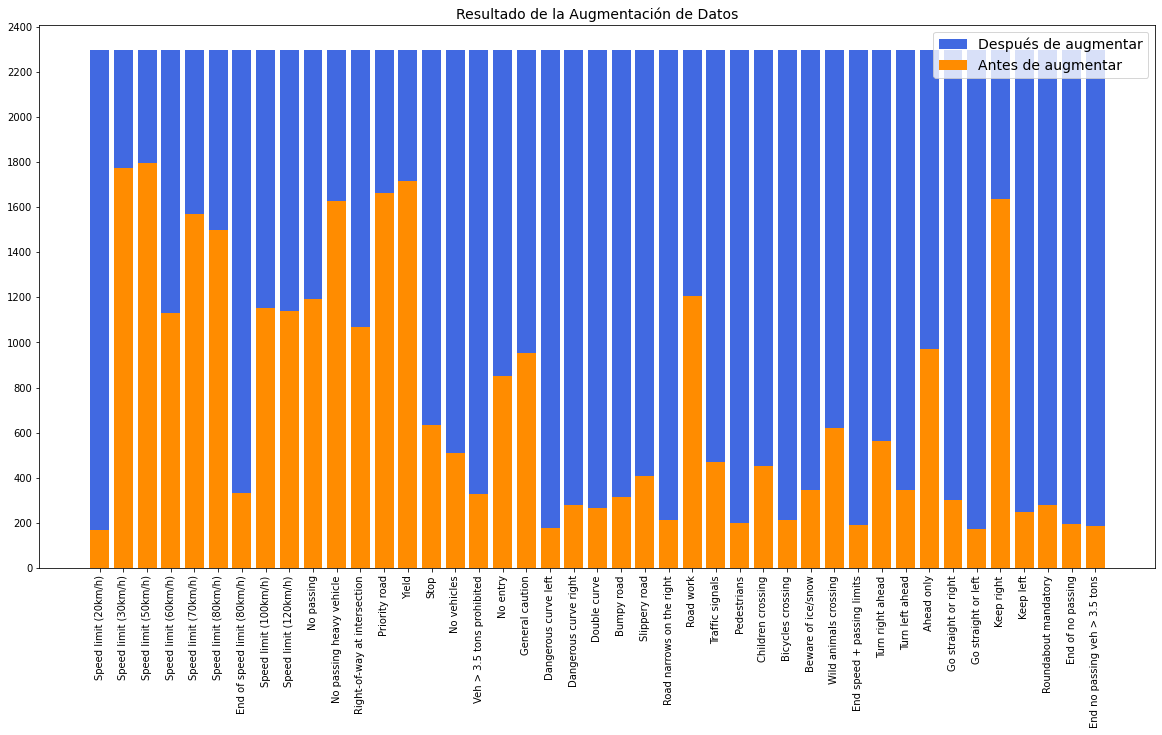

In [ ]:
#Displays class distribution and class examples
def get_histogram_data(x, y, x_new, y_new, class_names):
    classes = np.unique(y, return_index = True, return_counts = True)
    aug_classes = np.unique(y_new, return_index = True, return_counts = True)
    plt.figure(1, figsize=(20,10))
    plt.bar(class_names, aug_classes[2], label='Después de augmentar', color='royalblue')
    plt.bar(class_names, classes[2], label='Antes de augmentar', color='darkorange')
    plt.xticks(rotation=90)
    plt.yticks(range(0,np.max(aug_classes[2])+200,200))
    plt.title('Resultado de la Augmentación de Datos', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
get_histogram_data(train_images, train_labels, train_images_AD, train_labels_AD, class_names)

## Importar dataset de entrenamiento augmentado

In [ ]:
!unzip '/content/drive/MyDrive/Posgrado/traffic_sign_detection/traffic_sign_classifier/Dataset/GTSRD_train_augmented.zip' -d "/content" > /dev/null 

replace /content/GTSRD_augmented_local/image_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
def load_train_aug_images(path_images_folder, path_labels_file):
    #path_csv: path del archivo .csv que contiene información sobre cada imagen del set (train.csv o test.csv)
    images = []
    aug_train_labels = pd.read_pickle(path_labels_file) #Leo las etiquetas del set de entrenamiento guardadas
    
    images_list = os.listdir(path_images_folder)
    
    for _, path in enumerate(images_list): #count=contador - values=valor de cada elemento de data mientras itera
        image_path = os.path.join(path_images_folder, path) #crea el path completo de la imagen
        image = cv2.imread(image_path).astype('uint8') #lee la imagen
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #Actualizo la lista de imagenes y de labels
        images.append(image)
 
    images = np.array(images, dtype=object)#.astype('uint8')/255 #convierte las imagenes finales en arreglo numpy para facilitar el manejo posterior
    return images, aug_train_labels

In [ ]:
path_images_folder = '/content/GTSRD_augmented_local'
path_labels_file = '/content/train_labels_AD.pickle'

aug_train_images, aug_train_labels = load_train_aug_images(path_images_folder, path_labels_file)

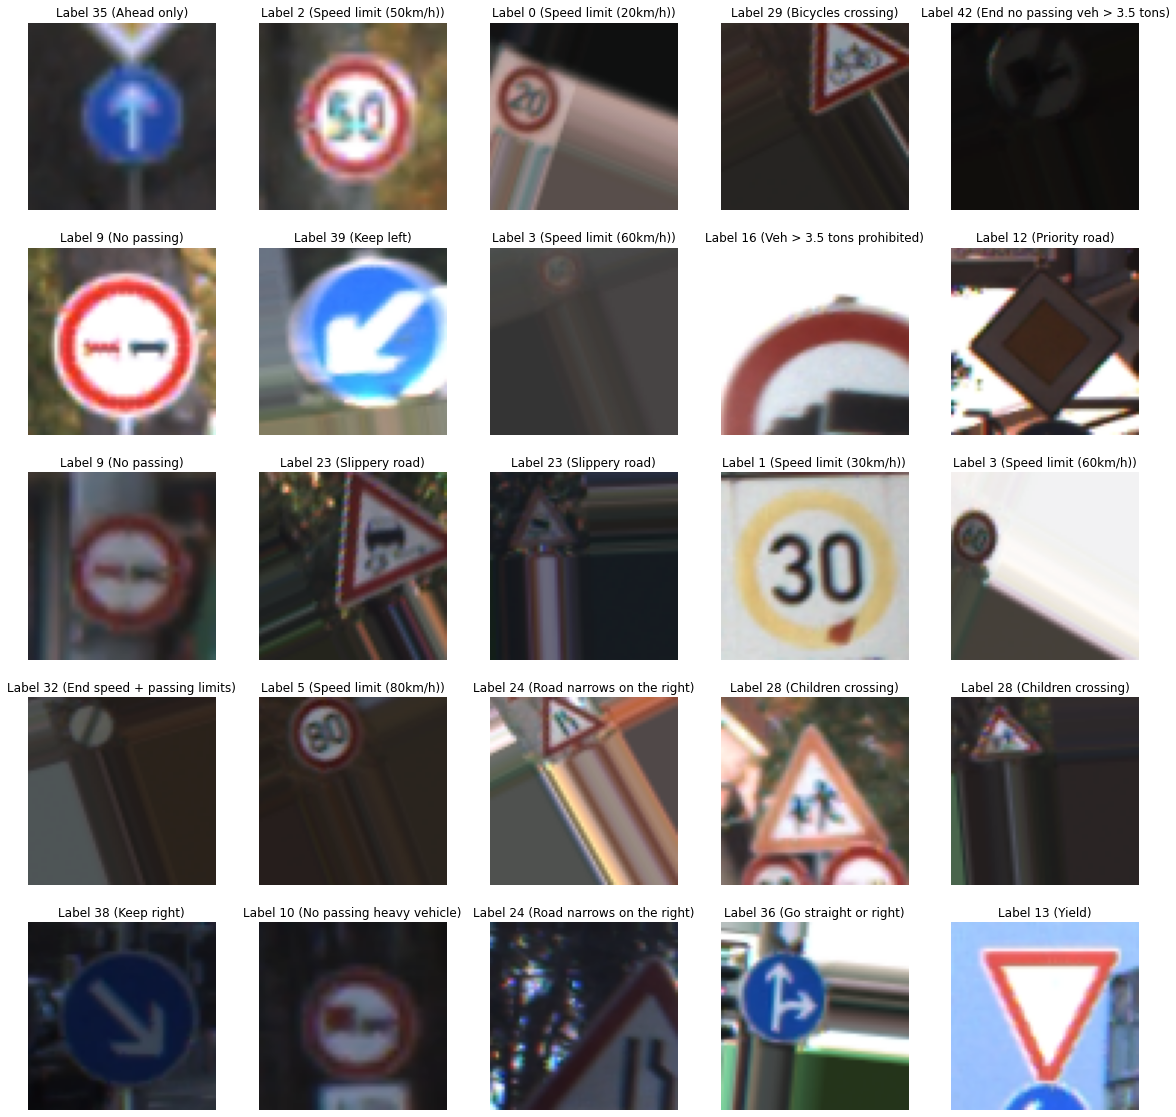

In [ ]:
plt.figure(figsize=(20,20))
for i in range(25):
    n =  random.randint(0, aug_train_labels.shape[0] - 1)
    image = cv2.imread(f'/content/GTSRD_augmented_local/image_{n}.png')
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.title("Label {0} ({1})".format(aug_train_labels[n],class_names[aug_train_labels[n]]))
    plt.imshow(image)

plt.show()

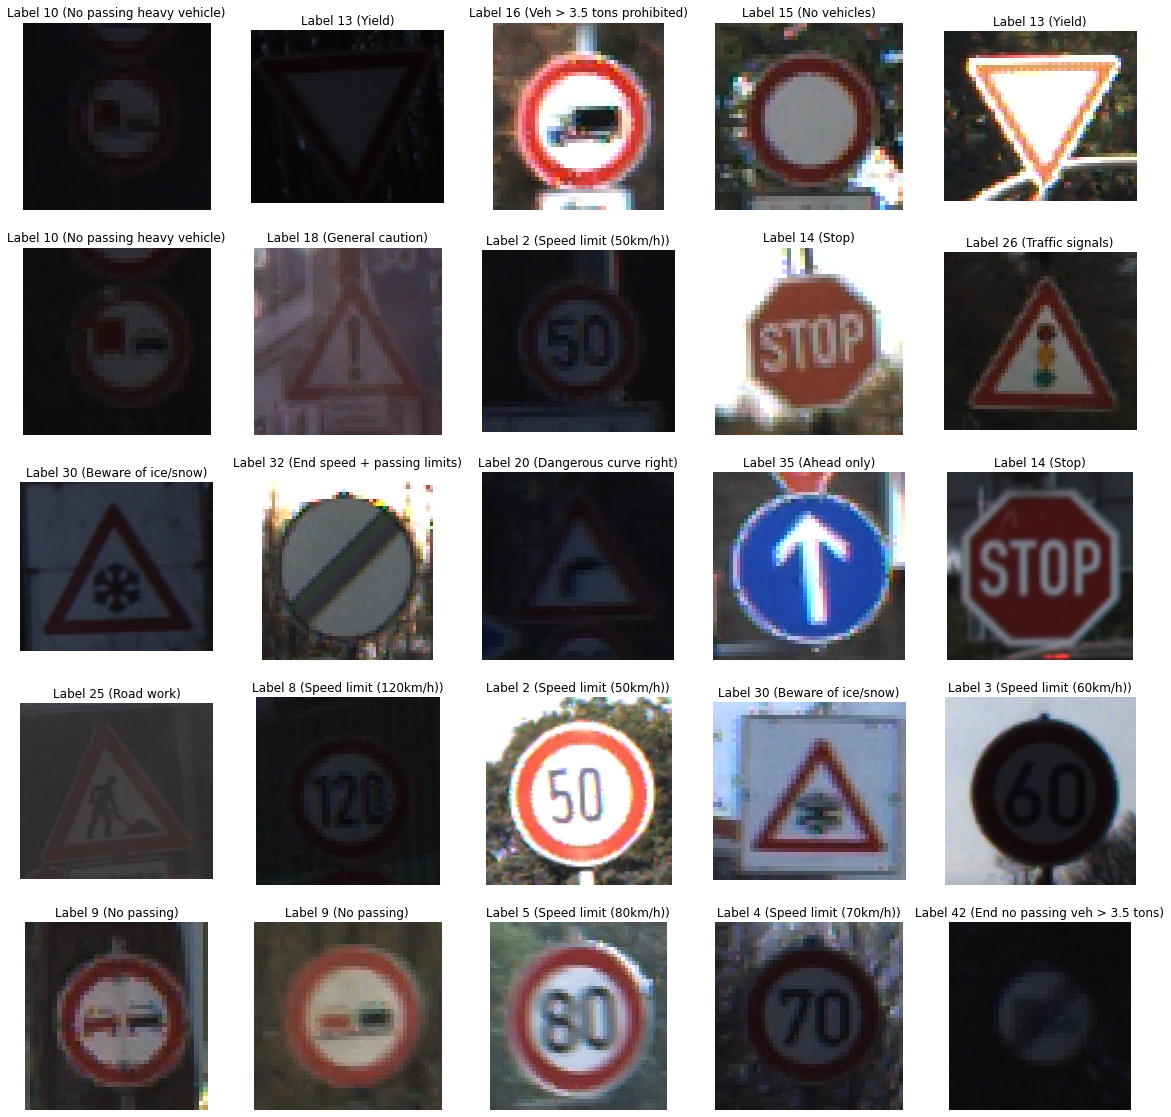

In [ ]:
plt.figure(figsize=(20,20))
for i in range(25):
    n =  random.randint(0, valid_labels.shape[0] - 1)
    image = valid_images[n]
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.title("Label {0} ({1})".format(valid_labels[n],class_names[valid_labels[n]]))
    plt.imshow(image)

plt.show()

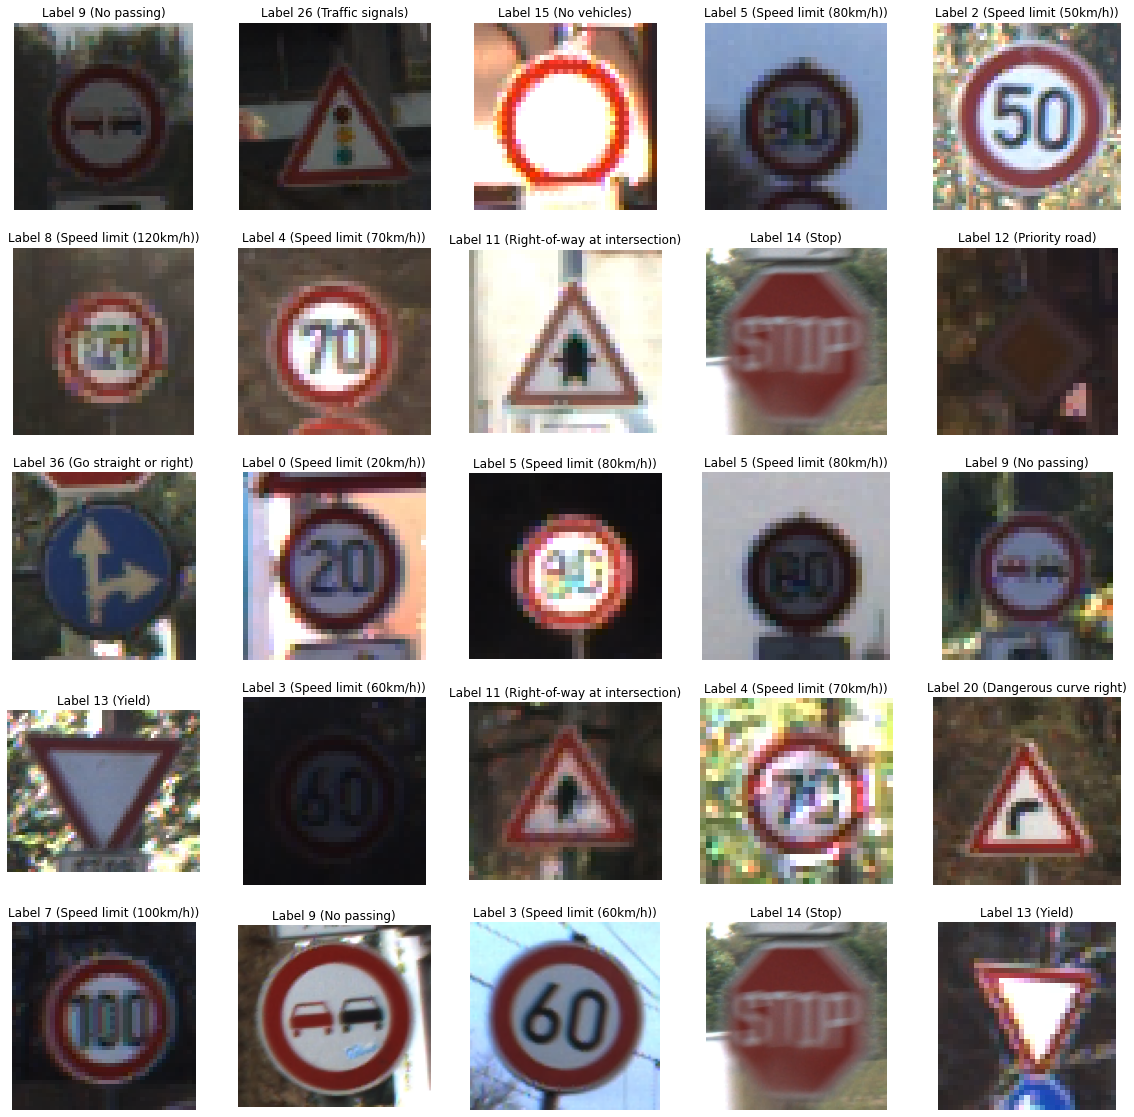

In [ ]:
plt.figure(figsize=(20,20))
for i in range(25):
    n =  random.randint(0, test_labels.shape[0] - 1)
    image = test_images[n]
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.title("Label {0} ({1})".format(test_labels[n],class_names[test_labels[n]]))
    plt.imshow(image)

plt.show()